<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Bayesian-R2" data-toc-modified-id="Bayesian-R2-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bayesian R2</a></span></li><li><span><a href="#Effective-sample-size" data-toc-modified-id="Effective-sample-size-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Effective sample size</a></span></li><li><span><a href="#Log-likelihood" data-toc-modified-id="Log-likelihood-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Log likelihood</a></span></li><li><span><a href="#Rhat" data-toc-modified-id="Rhat-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Rhat</a></span></li></ul></div>

In [1]:
import os
import glob
import biom
import numpy as np
import pandas as pd
import xarray as xr
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import dask
from dask.distributed import Client
from arviz.utils import Dask
benchmarking_dir = '../sfari/data/sra/Benchmarking'

dask.config.set(temporary_directory='/scratch')
%matplotlib inline

In [2]:
Dask.enable_dask(dask_kwargs={"dask": "parallelized", "output_dtypes": [float]})
client = Client(threads_per_worker=2, n_workers=60, memory_limit="20GB")

In [3]:
mean_files = glob.glob(f'{benchmarking_dir}/mean_differentials*.nc')
match_files = glob.glob(f'{benchmarking_dir}/differentials*-v5.nc')
biom_files = glob.glob(f'{benchmarking_dir}/matched*')
mean_files.sort()
match_files.sort()
biom_files.sort()

In [4]:
mean_files

['../sfari/data/sra/Benchmarking/mean_differentials_0.nc',
 '../sfari/data/sra/Benchmarking/mean_differentials_1.nc',
 '../sfari/data/sra/Benchmarking/mean_differentials_2.nc',
 '../sfari/data/sra/Benchmarking/mean_differentials_3.nc',
 '../sfari/data/sra/Benchmarking/mean_differentials_4.nc',
 '../sfari/data/sra/Benchmarking/mean_differentials_5.nc',
 '../sfari/data/sra/Benchmarking/mean_differentials_6.nc']

In [5]:
match_files

['../sfari/data/sra/Benchmarking/differentials_0-v5.nc',
 '../sfari/data/sra/Benchmarking/differentials_1-v5.nc',
 '../sfari/data/sra/Benchmarking/differentials_2-v5.nc',
 '../sfari/data/sra/Benchmarking/differentials_3-v5.nc',
 '../sfari/data/sra/Benchmarking/differentials_4-v5.nc',
 '../sfari/data/sra/Benchmarking/differentials_5-v5.nc',
 '../sfari/data/sra/Benchmarking/differentials_6-v5.nc']

In [6]:
biom_files

['../sfari/data/sra/Benchmarking/matched_0.biom',
 '../sfari/data/sra/Benchmarking/matched_1.biom',
 '../sfari/data/sra/Benchmarking/matched_2.biom',
 '../sfari/data/sra/Benchmarking/matched_3.biom',
 '../sfari/data/sra/Benchmarking/matched_4.biom',
 '../sfari/data/sra/Benchmarking/matched_5.biom',
 '../sfari/data/sra/Benchmarking/matched_6.biom']

In [7]:
mean_kwargs={'posterior':{'chunks': {'feature': 100}}}
match_kwargs={'posterior':{'chunks': {'features': 100}}}

mean_diffs = [az.from_netcdf(x, group_kwargs=mean_kwargs) for x in mean_files]
match_diffs = [az.from_netcdf(x, group_kwargs=match_kwargs) for x in match_files]
bioms = [biom.load_table(x) for x in biom_files]

In [8]:
bioms[1]

724 x 182 <class 'biom.table.Table'> with 17693 nonzero entries (13% dense)

In [9]:
mean_diffs[0].posterior

<xarray.Dataset>
Dimensions:  (chain: 4, draw: 100, feature: 537, group: 2)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9 ... 90 91 92 93 94 95 96 97 98 99
  * group    (group) object 'Control' '1'
  * feature  (feature) object 'AACGTAGGGTGCAAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...
Data variables:
    beta     (feature, chain, draw) float64 dask.array<chunksize=(100, 4, 100), meta=np.ndarray>
    alpha    (feature, chain, draw, group) float64 dask.array<chunksize=(100, 4, 100, 2), meta=np.ndarray>
Attributes:
    created_at:                 2021-10-07T21:13:18.972299
    arviz_version:              0.11.2
    inference_library:          cmdstanpy
    inference_library_version:  0.9.68

# Bayesian R2

In [10]:
def r2_match_func(x):
    m, b = x
    y_obs = xr.DataArray(b.matrix_data.todense())
    y_obs = y_obs.stack(feature=('dim_0', 'dim_1'))
    y_pred = m.posterior_predictive.stack(xsample=("chain", "draw"))
    y_pred = y_pred.stack(feature=('features', 'samples'))['y_predict']
    y_pred = y_pred.fillna(0)  # get rid of nans
    return az.r2_score(y_obs.values, y_pred.values)

def r2_mean_func(x):
    m, b = x
    y_obs = xr.DataArray(b.matrix_data.todense())
    y_obs = y_obs.stack(feature=('dim_0', 'dim_1'))
    y_pred = m.posterior_predictive.stack(xsample=("chain", "draw"))
    y_pred = y_pred.stack(xfeature=('feature', 'tbl_sample'))['y_predict']
    y_pred = y_pred.fillna(0)  # get rid of nans
    return az.r2_score(y_obs.values, y_pred.values)

In [11]:
mean_diffs[0]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

In [12]:
match_diffs[0]

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats

In [13]:
bioms

[537 x 172 <class 'biom.table.Table'> with 17481 nonzero entries (18% dense),
 724 x 182 <class 'biom.table.Table'> with 17693 nonzero entries (13% dense),
 818 x 216 <class 'biom.table.Table'> with 22403 nonzero entries (12% dense),
 923 x 260 <class 'biom.table.Table'> with 27648 nonzero entries (11% dense),
 1058 x 338 <class 'biom.table.Table'> with 36404 nonzero entries (10% dense),
 1525 x 406 <class 'biom.table.Table'> with 56247 nonzero entries (9% dense),
 2105 x 684 <class 'biom.table.Table'> with 149409 nonzero entries (10% dense)]

In [14]:
mean_r2 = dask.compute(*[r2_mean_func(x) for x in zip(mean_diffs, bioms)])
match_r2 = dask.compute(*[r2_match_func(x) for x in zip(match_diffs, bioms)])

In [15]:
mean_r2 = pd.concat(mean_r2, axis=1).T
match_r2 = pd.concat(match_r2, axis=1).T

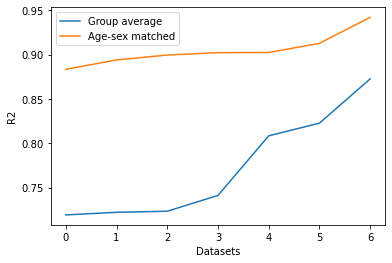

In [16]:
plt.plot(np.arange(len(mean_r2)), mean_r2.r2, label='Group average')
plt.plot(np.arange(len(match_r2)), match_r2.r2, label='Age-sex matched')
plt.ylabel('R2')
plt.xlabel('Datasets')
plt.legend()

In [17]:
mean_r2.to_csv('../results/benchmarking/mean_r2.csv')
match_r2.to_csv('../results/benchmarking/match_r2.csv')

# Effective sample size

In [18]:
mean_ess = dask.compute(*[az.ess(x) for x in mean_diffs])
match_ess = dask.compute(*[az.ess(x) for x in match_diffs])

In [19]:
mean_mess = dask.compute(*[x['beta'].mean() for x in mean_ess])
match_mess = dask.compute(*[x['diff'].mean() for x in match_ess])

In [20]:
mean_sess = dask.compute(*[x['beta'].std() for x in mean_ess])
match_sess = dask.compute(*[x['diff'].std() for x in match_ess])

In [21]:
mean_mess = np.hstack(mean_mess)
match_mess = np.hstack(match_mess)

mean_sess = np.hstack(mean_sess)
match_sess = np.hstack(match_sess)

Text(0.5, 0, 'Datasets')

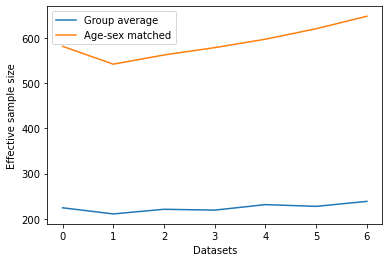

In [22]:
plt.plot(mean_mess, label='Group average')
plt.plot(match_mess, label='Age-sex matched')
plt.legend()
plt.ylabel('Effective sample size')
plt.xlabel('Datasets')

In [23]:
pd.DataFrame({'mean_ess': mean_mess, 'std_ess': mean_sess}).to_csv('../results/benchmarking/mean_ess.csv')
pd.DataFrame({'match_ess': match_mess, 'std_ess': match_sess}).to_csv('../results/benchmarking/match_ess.csv')

# Log likelihood

In [24]:
mean_ll = dask.compute(*[x.log_likelihood.log_lhood.mean() for x in mean_diffs])
match_ll = dask.compute(*[x.log_likelihood.log_lhood.mean() for x in match_diffs])

In [25]:
mean_ll = np.hstack(mean_ll)
match_ll = np.hstack(match_ll)

Text(0.5, 0, 'Datasets')

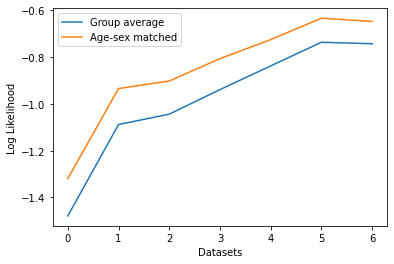

In [26]:
plt.plot(mean_ll, label='Group average')
plt.plot(match_ll, label='Age-sex matched')
plt.legend()
plt.ylabel('Log Likelihood')
plt.xlabel('Datasets')

In [27]:
pd.DataFrame({'mean_ll': mean_ll}).to_csv('../results/benchmarking/mean_ll.csv')
pd.DataFrame({'match_ll': match_ll}).to_csv('../results/benchmarking/match_ll.csv')

# Rhat

In [28]:
mean_rhat = dask.compute(*[az.rhat(x) for x in mean_diffs])
match_rhat = dask.compute(*[az.rhat(x) for x in match_diffs])

In [29]:
mean_mrhat = dask.compute(*[x['beta'].mean() for x in mean_rhat])
match_mrhat = dask.compute(*[x['diff'].mean() for x in match_rhat])

mean_srhat = dask.compute(*[x['beta'].std() for x in mean_rhat])
match_srhat = dask.compute(*[x['diff'].std() for x in match_rhat])

mean_mrhat = np.hstack(mean_mrhat)
match_mrhat = np.hstack(match_mrhat)

mean_srhat = np.hstack(mean_srhat)
match_srhat = np.hstack(match_srhat)

Text(0.5, 0, 'Datasets')

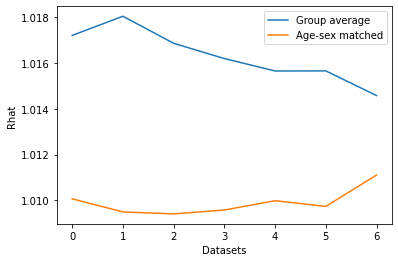

In [30]:
plt.plot(mean_mrhat, label='Group average')
plt.plot(match_mrhat, label='Age-sex matched')
plt.legend()
plt.ylabel('Rhat')
plt.xlabel('Datasets')

In [31]:
pd.DataFrame({'mean_rhat': mean_mrhat, 'std_rhat': mean_srhat}).to_csv('../results/benchmarking/mean_rhat.csv')
pd.DataFrame({'match_rhat': match_mrhat, 'std_rhat': match_srhat}).to_csv('../results/benchmarking/match_rhat.csv')

In [32]:
# LOO

In [33]:
mean_loo = dask.compute(*[az.loo(x) for x in mean_diffs])
match_loo = dask.compute(*[az.loo(x) for x in match_diffs])

/mnt/home/jmorton/software/arviz/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/mnt/home/jmorton/software/arviz/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/mnt/home/jmorton/software/arviz/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of P

In [34]:
print(mean_loo)

(Computed from 400 by 92364 log-likelihood matrix

         Estimate       SE
elpd_loo -137450.60   849.23
p_loo     1520.07        -

There has been a warning during the calculation. Please check the results., Computed from 400 by 131768 log-likelihood matrix

         Estimate       SE
elpd_loo -144497.31   911.37
p_loo     1934.02        -

There has been a warning during the calculation. Please check the results., Computed from 400 by 176688 log-likelihood matrix

         Estimate       SE
elpd_loo -185665.07  1049.12
p_loo     2154.38        -

There has been a warning during the calculation. Please check the results., Computed from 400 by 239980 log-likelihood matrix

         Estimate       SE
elpd_loo -226722.66  1160.17
p_loo     2505.75        -

There has been a warning during the calculation. Please check the results., Computed from 400 by 357604 log-likelihood matrix

         Estimate       SE
elpd_loo -301153.03  1360.36
p_loo     2926.17        -

There has been a warn

In [35]:
print(match_loo)

(Computed from 400 by 92364 log-likelihood matrix

         Estimate       SE
elpd_loo -131796.91   845.22
p_loo    16269.31        -

There has been a warning during the calculation. Please check the results., Computed from 400 by 131768 log-likelihood matrix

         Estimate       SE
elpd_loo -135373.58   892.73
p_loo    19526.19        -

There has been a warning during the calculation. Please check the results., Computed from 400 by 176688 log-likelihood matrix

         Estimate       SE
elpd_loo -175492.26  1033.87
p_loo    25988.69        -

There has been a warning during the calculation. Please check the results., Computed from 400 by 239980 log-likelihood matrix

         Estimate       SE
elpd_loo -213895.14  1140.86
p_loo    32777.76        -

There has been a warning during the calculation. Please check the results., Computed from 400 by 357604 log-likelihood matrix

         Estimate       SE
elpd_loo -284277.78  1335.71
p_loo    40334.17        -

There has been a warn

In [36]:
mean_loo_df = pd.DataFrame({'mean' : [-78035.36, -635246.04, -429322.72, -792869.93, -881582.72, -981949.15, -1025531.15, -1087078.24],
                             'std': [600.93, 1654.56, 1657.31, 1943.93, 2087.67, 2260.78, 2322.65, 2448.26]})
match_loo_df = pd.DataFrame({'mean' : [-86991.67, -716614.35, -434454.87, -878872.95, -972598.28, -1066462.16, -1110604.03, -1163664.22],
                             'std': [764.50, 2093.97, 1846.73, 2393.52, 2548.59, 2716.40, 2775.82, 2874.13]})

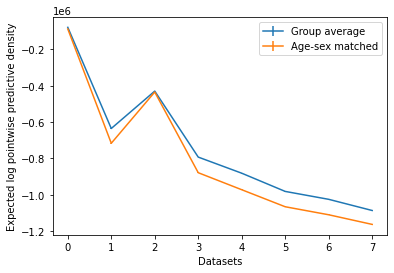

In [37]:
x = np.arange(len(mean_loo_df))
plt.errorbar(x, y=mean_loo_df['mean'], yerr=mean_loo_df['std'], label='Group average')
plt.errorbar(x, y=match_loo_df['mean'], yerr=match_loo_df['std'], label='Age-sex matched')
plt.ylabel('Expected log pointwise predictive density')
plt.xlabel('Datasets')
plt.legend()

In [38]:
mean_loo_df.to_csv('../results/benchmarking/mean_loo.csv')
match_loo_df.to_csv('../results/benchmarking/match_loo.csv')

In [39]:
client.close()